In [1]:
import os
import concurrent.futures

In [2]:
import h5py
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import lib

In [4]:
# os.environ["PATH"] += ":/global/common/software/nersc9/texlive/2024/bin/x86_64-linux"
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"
os.environ["MEDS_DIR"] = "/global/cfs/cdirs/desbalro"

In [5]:
lib.plotting.setup()

In [6]:
onecolumn_kwargs = {
    "width": 2,
    "height": 2,
    "margin": 1,
    "gutter": 1,
    "fig_width": 4,
    "fig_height": 4,
}
twocolumn_kwargs = {
    "width": 6,
    "height": 2,
    "margin": 1,
    "gutter": 1,
    "fig_width": 8,
    "fig_height": 4,
}

In [7]:
shear_step_plus = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"
shear_step_minus = "g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

assert shear_step_plus in lib.const.SHEAR_STEPS
assert shear_step_minus in lib.const.SHEAR_STEPS

In [8]:
imsim_catalog_plus = lib.const.IMSIM_CATALOGS[shear_step_plus]
imsim_catalog_minus = lib.const.IMSIM_CATALOGS[shear_step_minus]

In [9]:
with (
    h5py.File(imsim_catalog_plus) as hf_imsim_plus,
    h5py.File(imsim_catalog_minus) as hf_imsim_minus,
):
    tiles = np.intersect1d(
        hf_imsim_plus["mdet"]["noshear"]["tilename"][:].astype(str),
        hf_imsim_minus["mdet"]["noshear"]["tilename"][:].astype(str),
    )

In [10]:
def compute_mag(data, mask, band):

    flux = data[f"pgauss_band_flux_{band}"][mask]

    mag = -2.5 * np.log10(flux) + 30

    return mag


def compute_color(data, mask, bands):

    flux_1 = data[f"pgauss_band_flux_{bands[0]}"][mask]
    flux_2 = data[f"pgauss_band_flux_{bands[1]}"][mask]

    color = -2.5 * np.log10(flux_1 / flux_2)

    return color


def mag_hist(data, mask, band, bins):
    mag = compute_mag(data, mask, band)
    # hist, _ = np.histogram(mag, bins=bins)
    hist, _, _ = stats.binned_statistic(
        mag,
        None,
        statistic="count",
        bins=bins,
    )
    return hist


def mag_color_hist(data, mask, band_x, bands_y, bins):
    # color_x = compute_color(data, mask, bands_x)
    mag_x = compute_mag(data, mask, band_x)
    color_y = compute_color(data, mask, bands_y)
    # hist, _, _ = np.histogram2d(color_x, color_y, bins=bins)
    hist, _, _, _ = stats.binned_statistic_2d(
        mag_x,
        color_y,
        None,
        statistic="count",
        bins=bins,
    )
    return hist


def color_color_hist(data, mask, bands_x, bands_y, bins):
    color_x = compute_color(data, mask, bands_x)
    color_y = compute_color(data, mask, bands_y)
    # hist, _, _ = np.histogram2d(color_x, color_y, bins=bins)
    hist, _, _, _ = stats.binned_statistic_2d(
        color_x,
        color_y,
        None,
        statistic="count",
        bins=bins,
    )
    return hist


def multiband_hist(data, mask, bands_x, bands_y, bins):
    match len(bands_x):
        case 1:
            value_x = compute_mag(data, mask, bands_x)
        case 2:
            value_x = compute_color(data, mask, bands_x)
        case _:
            raise ValueError(f"Invalid bands for color or magnitude")
    match len(bands_y):
        case 1:
            value_y = compute_mag(data, mask, bands_y)
        case 2:
            value_y = compute_color(data, mask, bands_y)
        case _:
            raise ValueError(f"Invalid bands for color or magnitude")
    hist, _, _ = np.histogram2d(value_x, value_y, bins=bins)
    # hist, _, _, _ = stats.binned_statistic_2d(
    #     value_x,
    #     value_y,
    #     None,
    #     statistic="count",
    #     bins=bins,
    # )
    return hist


def format_band(band):
    return f"${{{band}}}$"


def format_bands(bands):
    match len(bands):
        case 1:
            TeXstring = f"${{{bands}}}$"
        case 2:
            TeXstring = f"${{{bands[0]}}} - {{{bands[1]}}}$"
        case _:
            raise ValueError(f"Invalid bands for color or magnitude")
    return TeXstring



In [11]:
mdet_mask = lib.util.load_mdet_mask()
mdet_area = mdet_mask.get_valid_area()

# Luminosity

In [12]:
NBINS = 100
BINS = {
    "g": np.linspace(13, 27, NBINS + 1),
    "r": np.linspace(13, 27, NBINS + 1),
    "i": np.linspace(13, 27, NBINS + 1),
    "z": np.linspace(13, 27, NBINS + 1),
}

band = "i"
bins = BINS[band]

In [13]:
futures = []
with h5py.File(lib.const.MDET_CATALOG) as hf:
    dset = hf["mdet"]["noshear"]

    for i, chunk in enumerate(dset["patch_num"].iter_chunks()):
        _start = chunk[0].start
        _stop = chunk[0].stop
        _step = chunk[0].step
        print(f"processing chunk {i + 1} -- {_start}:{_stop}:{_step}", end="\r", flush=True)
        with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
            _future = executor.submit(mag_hist, dset, chunk, band, bins)
            futures.append(_future)

# hist = np.nansum([hist, _hist], axis=0)

# hist /= mdet_area

In [14]:
hist = np.zeros(NBINS)
for future in futures:
    _hist = future.result()
    hist = np.nansum([hist, _hist], axis=0)
    
hist /= mdet_area

In [15]:
def accumulate_hist_pair(imsim_catalog_plus, imsim_catalog_minus, tile, band, bins):
    with h5py.File(imsim_catalog_plus) as hf_imsim_plus:
        data_p = hf_imsim_plus["mdet"]["noshear"]
        in_tile_p = data_p["tilename"][:].astype(str) == tile
        hist_p = mag_hist(data_p, in_tile_p, band, bins)

    with h5py.File(imsim_catalog_minus) as hf_imsim_minus:
        data_m = hf_imsim_minus["mdet"]["noshear"]
        in_tile_m = data_m["tilename"][:].astype(str) == tile
        hist_m = mag_hist(data_m, in_tile_m, band, bins)

    return hist_p, hist_m

def accumulate_area_pair(tile, band, mdet_mask):
    tile_area_p = lib.util.get_tile_area(
        tile,
        band,
        shear="plus",
        mdet_mask=mdet_mask,
    )
    tile_area_m = lib.util.get_tile_area(
        tile,
        band,
        shear="minus",
        mdet_mask=mdet_mask,
    )

    return tile_area_p, tile_area_m

In [16]:
N_TEST = 8  # len(tiles)

In [17]:
hist_futures = {}
with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    for i, tile in enumerate(tiles[:N_TEST]):
        _future = executor.submit(
            accumulate_hist_pair,
            imsim_catalog_plus,
            imsim_catalog_minus,
            tile,
            band,
            bins,
        )
        hist_futures[tile] = _future

In [18]:
area_futures = {}
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    for i, tile in enumerate(tiles[:N_TEST]):
        _future = executor.submit(
            accumulate_area_pair,
            tile,
            band,
            mdet_mask,
        )
        area_futures[tile] = _future

In [19]:
hist_p = np.zeros(NBINS)
hist_m = np.zeros(NBINS)
area_p = 0
area_m = 0


for tile in tiles:
    if (
        (_hist_future := hist_futures.get(tile)) is not None
    ) and (
        (_area_future := area_futures.get(tile)) is not None
    ):
        _hist_p, _hist_m = _hist_future.result()
        _area_p, _area_m = _area_future.result()
        
        hist_p = np.nansum([hist_p, _hist_p], axis=0)
        area_p += _area_p
        hist_m = np.nansum([hist_m, _hist_m], axis=0)
        area_m += _area_m


hist_sims = np.nanmean([hist_p / area_p, hist_m / area_m], axis=0)

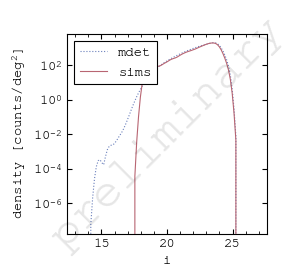

In [21]:
fig, axs = lib.plotting.make_axes(
    1, 1,
    **onecolumn_kwargs,
)


cmap_mdet = "des-y6-mdet"
cmap_sims = "des-y6-sims"

lib.plotting.contour1d(
    axs,
    hist,
    bins,
    color=lib.plotting.mdet_color,
    ls=":",
    label="mdet",
)
lib.plotting.contour1d(
    axs,
    hist_sims,
    bins,
    color=lib.plotting.sims_color,
    label="sims",
)
axs.set_xlabel(format_band(band))
axs.set_ylabel(f"density [$counts / deg^2$]")
axs.set_yscale("log")
axs.legend(loc="upper left")

# axs.text(
#     0.05, 0.95,
#     "mdet",
#     color=lib.plotting.mdet_color,
#     transform=axs.transAxes,
#     horizontalalignment="left",
#     verticalalignment="top",
# )
# axs.text(
#     0.05, 0.85,
#     "sims",
#     color=lib.plotting.sims_color,
#     transform=axs.transAxes,
#     horizontalalignment="left",
#     verticalalignment="top",
# )

lib.plotting.watermark(fig)

fig.savefig("luminosity.pdf")

plt.show()

# Color-color

In [21]:
def accumulate_pair(*, pdict, mdict, tile, bands_x, bands_y, bins, mdet_mask):
    fplus = pdict["catalog"]
    fminus = mdict["catalog"]

    data_p = load_file(fplus)
    data_m = load_file(fminus)

    cuts_p = selections.get_selection(data_p)
    cuts_m = selections.get_selection(data_m)

    hist_p = multiband_hist(data_p, cuts_p, bands_x, bands_y, bins)
    hist_m = multiband_hist(data_m, cuts_m, bands_x, bands_y, bins)

    tile_area_p = util.get_tile_area(
        tile,
        "r",
        shear="plus",
        pizza_slices_dir=pdict["pizza_slices_dir"],
        des_pizza_slices_dir=os.environ["IMSIM_DATA"],
        mdet_mask=mdet_mask,
    )
    tile_area_m = util.get_tile_area(
        tile,
        "r",
        shear="minus",
        pizza_slices_dir=mdict["pizza_slices_dir"],
        des_pizza_slices_dir=os.environ["IMSIM_DATA"],
        mdet_mask=mdet_mask,
    )

    return hist_p, tile_area_p, hist_m, tile_area_m

In [22]:
NBINS = 100
BINS = {
    "gr": np.linspace(-2, 4, NBINS),
    "ri": np.linspace(-2, 4, NBINS),
}


bands_x = "gr"
bands_y = "ri"

bins = (BINS[bands_x], BINS[bands_y])

In [23]:
hist = np.zeros(
    (len(bins[0]) - 1, len(bins[1]) - 1)
)
with h5py.File(
    "/dvs_ro/cfs/projectdirs/des/y6-shear-catalogs/Y6A2_METADETECT_V6/metadetect_cutsv6_all_blinded.h5",
    # "/global/cfs/projectdirs/des/y6-shear-catalogs/Y6A2_METADETECT_V6/metadetect_cutsv6_all_blinded.h5",
    mode="r",
    locking=False
) as hf:
    dset = hf["mdet"]["noshear"]

    for sl in dset["patch_num"].iter_chunks():
        _hist = multiband_hist(dset, sl, bands_x, bands_y, bins)
        hist = np.nansum([hist, _hist], axis=0)

    hist /= mdet_area



In [24]:

jobs = [
    joblib.delayed(accumulate_pair)(pdict=sims["plus"], mdict=sims["minus"], tile=tile, bands_x=bands_x, bands_y=bands_y, bins=bins, mdet_mask=mdet_mask)
    for tile, seeds in pairs.items()
    for seed, sims in seeds.items()
]
print(f"Processing {len(jobs)} paired simulations")

hist_p = np.zeros((len(bins[0]) - 1, len(bins[1]) - 1))
hist_m = np.zeros((len(bins[0]) - 1, len(bins[1]) - 1))
area_p = 0
area_m = 0
with joblib.Parallel(n_jobs=8, backend="loky", verbose=10) as par:
    for res in par(jobs):
        hist_p = np.nansum([hist_p, res[0]], axis=0)
        area_p = np.nansum([area_p, res[1]], axis=0)
        hist_m = np.nansum([hist_m, res[2]], axis=0)
        area_m = np.nansum([area_m, res[3]], axis=0)

hist_sims = np.nanmean([hist_p / area_p, hist_m / area_m], axis=0)


NameError: name 'pairs' is not defined

In [ ]:

fig, axs = plotting.make_axes(
    1, 1,
    **beamer_kwargs,
)


# https://corner.readthedocs.io/en/latest/pages/sigmas/
# percentiles = [50.00, 70.00, 90.00]
# percentiles = 1.0 - np.exp(-0.5 * np.array([0.5, 1.0, 1.5, 2.0]) ** 2)
# percentiles = [0.5, 0.7, 0.9]
percentiles = 1.0 - np.exp(-0.5 * np.array([1.5, 2.0, 2.5, 3.0]) ** 2)
levels = util.get_levels(hist, percentiles=percentiles)

cmap_mdet = "des-y6-mdet"
cmap_sims = "des-y6-sims"

norm = colors.LogNorm()

ax = axs[0, 0]

contours = plotting.contour(ax, hist, bins, norm=norm, levels=levels, cmap=cmap_mdet)
contours = plotting.contour(ax, hist_sims, bins, norm=norm, levels=levels, cmap=cmap_sims)
ax.set_xlabel(format_bands(bands_x))
ax.set_ylabel(format_bands(bands_y))

ax.text(
    0.05, 0.95,
    "mdet",
    color=plotting.mdet_color,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="top",
)
ax.text(
    0.05, 0.85,
    "sims",
    color=plotting.sims_color,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="top",
)


fig.savefig("color-color.pdf")

plt.show()

# Size

In [ ]:
def compute_logsnr(data, mask):

    snr = data[f"gauss_s2n"][mask]
    logsnr = np.log10(snr)

    return logsnr


def compute_logsize(data, mask):

    T_ratio = data[f"gauss_T_ratio"][mask]
    psf_T = data[f"gauss_psf_T"][mask]

    size = T_ratio * psf_T

    logsize = np.log10(1 + size)

    return logsize

def size_snr_hist(data, mask, bins):
    value_x = compute_logsnr(data, mask)
    value_y = compute_logsize(data, mask)
    hist, _, _ = np.histogram2d(value_x, value_y, bins=bins)
    # hist, _, _, _ = stats.binned_statistic_2d(
    #     value_x,
    #     value_y,
    #     None,
    #     statistic="count",
    #     bins=bins,
    # )
    return hist

In [ ]:
def accumulate_pair(*, pdict, mdict, tile, bins, mdet_mask):
    fplus = pdict["catalog"]
    fminus = mdict["catalog"]

    data_p = load_file(fplus)
    data_m = load_file(fminus)

    cuts_p = selections.get_selection(data_p)
    cuts_m = selections.get_selection(data_m)

    hist_p = size_snr_hist(data_p, cuts_p, bins)
    hist_m = size_snr_hist(data_m, cuts_m, bins)

    tile_area_p = util.get_tile_area(
        tile,
        "r",
        shear="plus",
        pizza_slices_dir=pdict["pizza_slices_dir"],
        des_pizza_slices_dir=os.environ["IMSIM_DATA"],
        mdet_mask=mdet_mask,
    )
    tile_area_m = util.get_tile_area(
        tile,
        "r",
        shear="minus",
        pizza_slices_dir=mdict["pizza_slices_dir"],
        des_pizza_slices_dir=os.environ["IMSIM_DATA"],
        mdet_mask=mdet_mask,
    )

    return hist_p, tile_area_p, hist_m, tile_area_m

In [ ]:
NBINS = 100
BINS = {
    "logsnr": np.linspace(0.5, 2.5, NBINS),
    "logsize": np.linspace(-0.1, 0.4, NBINS),
}
bins = (BINS["logsnr"], BINS["logsize"])

In [ ]:
hist = np.zeros(
    (len(bins[0]) - 1, len(bins[1]) - 1)
)
with h5py.File(
    "/dvs_ro/cfs/projectdirs/des/y6-shear-catalogs/Y6A2_METADETECT_V6/metadetect_cutsv6_all_blinded.h5",
    # "/global/cfs/projectdirs/des/y6-shear-catalogs/Y6A2_METADETECT_V6/metadetect_cutsv6_all_blinded.h5",
    mode="r",
    locking=False
) as hf:
    dset = hf["mdet"]["noshear"]

    for sl in dset["patch_num"].iter_chunks():
        _hist = size_snr_hist(dset, sl, bins)
        hist = np.nansum([hist, _hist], axis=0)

    hist /= mdet_area


In [ ]:
jobs = [
    joblib.delayed(accumulate_pair)(pdict=sims["plus"], mdict=sims["minus"], tile=tile, bins=bins, mdet_mask=mdet_mask)
    for tile, seeds in pairs.items()
    for seed, sims in seeds.items()
]

print(f"Processing {len(jobs)} paired simulations")

hist_p = np.zeros((len(bins[0]) - 1, len(bins[1]) - 1))
hist_m = np.zeros((len(bins[0]) - 1, len(bins[1]) - 1))
area_p = 0
area_m = 0
with joblib.Parallel(n_jobs=8, backend="loky", verbose=10) as par:
    # d = par(jobs)
    for res in par(jobs):
        hist_p = np.nansum([hist_p, res[0]], axis=0)
        area_p = np.nansum([area_p, res[1]], axis=0)
        hist_m = np.nansum([hist_m, res[2]], axis=0)
        area_m = np.nansum([area_m, res[3]], axis=0)

hist_sims = np.nanmean([hist_p / area_p, hist_m / area_m], axis=0)

In [ ]:

fig, axs = plotting.make_axes(
    1, 1,
    **beamer_kwargs,
)


# https://corner.readthedocs.io/en/latest/pages/sigmas/
# percentiles = [50.00, 70.00, 90.00]
# percentiles = 1.0 - np.exp(-0.5 * np.array([0.5, 1.0, 1.5, 2.0]) ** 2)
# percentiles = [0.5, 0.7, 0.9]
percentiles = 1.0 - np.exp(-0.5 * np.array([1.5, 2.0, 2.5, 3.0]) ** 2)
levels = util.get_levels(hist, percentiles=percentiles)

cmap_mdet = "des-y6-mdet"
cmap_sims = "des-y6-sims"

norm = colors.LogNorm()

ax = axs[0, 0]

contours = plotting.contour(ax, hist, bins, norm=norm, levels=levels, cmap=cmap_mdet)
contours = plotting.contour(ax, hist_sims, bins, norm=norm, levels=levels, cmap=cmap_sims)
ax.set_xlabel("$\\log_{10}(S/N)$")
ax.set_ylabel("$\\log_{10}(1 + T)$")
ax.set_ylim(0)

ax.text(
    0.05, 0.95,
    "mdet",
    color=plotting.mdet_color,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="top",
)
ax.text(
    0.05, 0.85,
    "sims",
    color=plotting.sims_color,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="top",
)


fig.savefig("size-snr.pdf")

plt.show()

# Clustering

In [ ]:
def accumulate_pair(*, pdict, mdict, tile, bins, mdet_mask):
    # plus
    fplus = pdict["catalog"]

    data_p = load_file(fplus)
    cuts_p = selections.get_selection(data_p)

    matcher_p = smatch.Matcher(data_p[cuts_p]["ra"], data_p[cuts_p]["dec"])
    indices_p, distances_p = matcher_p.query_knn(matcher_p.lon, matcher_p.lat, k=2, return_distances=True)
    dnn_p = distances_p[:, 1] * 60 * 60
    del matcher_p, indices_p, distances_p

    hist_p, _ = np.histogram(dnn_p, bins=bins)
    del dnn_p

    tile_map_p = util.get_tile_mask(
        tile,
        "r",
        shear="plus",
        pizza_slices_dir=pdict["pizza_slices_dir"],
        des_pizza_slices_dir=os.environ["IMSIM_DATA"],
        mdet_mask=mdet_mask,
    )
    tile_area_p = tile_map_p.get_valid_area(degrees=True)

    n_sample_p = np.sum(cuts_p)

    rand_ra_p, rand_dec_p = healsparse.make_uniform_randoms(tile_map_p, n_sample_p)
    del tile_map_p

    rand_matcher_p = smatch.Matcher(rand_ra_p, rand_dec_p)
    rand_indices_p, rand_distances_p = rand_matcher_p.query_knn(rand_matcher_p.lon, rand_matcher_p.lat, k=2, return_distances=True)
    rand_dnn_p = rand_distances_p[:, 1] * 60 * 60
    del rand_matcher_p, rand_indices_p, rand_distances_p

    rand_hist_p, _ = np.histogram(rand_dnn_p, bins=bins)
    del rand_dnn_p

    # minus
    fminus = mdict["catalog"]

    data_m = load_file(fminus)
    cuts_m = selections.get_selection(data_m)

    matcher_m = smatch.Matcher(data_m[cuts_m]["ra"], data_m[cuts_m]["dec"])
    indices_m, distances_m = matcher_m.query_knn(matcher_m.lon, matcher_m.lat, k=2, return_distances=True)
    dnn_m = distances_m[:, 1] * 60 * 60
    del matcher_m, indices_m, distances_m

    hist_m, _ = np.histogram(dnn_m, bins=bins)
    del dnn_m


    tile_map_m = util.get_tile_mask(
        tile,
        "r",
        shear="minus",
        pizza_slices_dir=pdict["pizza_slices_dir"],
        des_pizza_slices_dir=os.environ["IMSIM_DATA"],
        mdet_mask=mdet_mask,
    )
    tile_area_m = tile_map_m.get_valid_area(degrees=True)

    n_sample_m = np.sum(cuts_m)                                                                                                                                                                                                                                                   

    rand_ra_m, rand_dec_m = healsparse.make_uniform_randoms(tile_map_m, n_sample_m)
    del tile_map_m

    rand_matcher_m = smatch.Matcher(rand_ra_m, rand_dec_m)
    rand_indices_m, rand_distances_m = rand_matcher_m.query_knn(rand_matcher_m.lon, rand_matcher_m.lat, k=2, return_distances=True)
    rand_dnn_m = rand_distances_m[:, 1] * 60 * 60
    del rand_matcher_m, rand_indices_m, rand_distances_m

    rand_hist_m, _ = np.histogram(rand_dnn_m, bins=bins)
    del rand_dnn_m

    return hist_p, rand_hist_p, tile_area_p, hist_m, rand_hist_m, tile_area_m


In [ ]:
NBINS = 100 
bins = np.geomspace(1e-2, 1, NBINS) * 60

In [ ]:
hist = np.zeros(
    len(bins) - 1 
)
with h5py.File(
    "/dvs_ro/cfs/projectdirs/des/y6-shear-catalogs/Y6A2_METADETECT_V6/metadetect_cutsv6_all_blinded.h5",
    # "/global/cfs/projectdirs/des/y6-shear-catalogs/Y6A2_METADETECT_V6/metadetect_cutsv6_all_blinded.h5",
    mode="r",
    locking=False
) as hf:
    dset = hf["mdet"]["noshear"]
    # sel = (dset["tilename"][:] == TILENAME)

    # matcher = smatch.Matcher(dset["ra"][sel], dset["dec"][sel])
    matcher = smatch.Matcher(dset["ra"], dset["dec"])
    indices, distances = matcher.query_knn(matcher.lon, matcher.lat, k=2, return_distances=True)
    dnn = distances[:, 1] * 60 * 60
    del matcher, indices, distances  # forecfully cleanup
    _hist, _ = np.histogram(dnn, bins=bins)
    hist += _hist

# hist /= mdet_area * sum(sel) / len(sel)
hist /= mdet_area

In [ ]:
jobs = [
    joblib.delayed(accumulate_pair)(pdict=sims["plus"], mdict=sims["minus"], tile=tile, bins=bins, mdet_mask=mdet_mask)
    for tile, seeds in pairs.items()
    for seed, sims in seeds.items()
]
print(f"Processing {len(jobs)} paired simulations")

hist_p = np.zeros(len(bins) - 1)
rand_hist_p = np.zeros(len(bins) - 1)
area_p = 0
hist_m = np.zeros(len(bins) - 1)
rand_hist_m = np.zeros(len(bins) - 1)
area_m = 0
with joblib.Parallel(n_jobs=8, backend="loky", verbose=10) as par:
    # d = par(jobs)
    for res in par(jobs):
        hist_p += res[0]
        rand_hist_p += res[1]
        area_p += res[2]
        hist_m += res[3]
        rand_hist_m += res[4]                                                                                                                                                                                                                                                 
        area_m += res[5]

hist_sims = np.nanmean([hist_p / area_p, hist_m / area_m], axis=0)
hist_rand = np.nanmean([rand_hist_p / area_p, rand_hist_m / area_m], axis=0)


In [ ]:
fig, axs = plotting.make_axes(
    1, 1,
    **beamer_kwargs,
)

ax = axs[0, 0]

plotting.contour1d(
    ax,
    hist,
    bins,
    color=plotting.mdet_color,
    label="mdet",
)
plotting.contour1d(
    ax,
    hist_rand,
    bins,
    color="gray",
    label="rand",
)
plotting.contour1d(
    ax,
    hist_sims,
    bins,
    color=plotting.sims_color,
    label="simcat",
)
ax.set_xlabel("$d_{nearest\ neighbor}$ [arcsec]")
ax.set_ylabel("density [$counts / deg^2$]")
# ax.legend(loc="upper left")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

ax.text(
    0.05, 0.95,
    "mdet",
    color=plotting.mdet_color,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="top",
)
ax.text(
    0.05, 0.85,
    "sims",
    color=plotting.sims_color,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="top",
)
ax.text(
    0.05, 0.75,
    "rand",
    color="gray",
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="top",
)
ax.set_ylim(0, None)

fig.savefig("clustering.pdf")

plt.show()
